In [1]:
import pandas as pd
import numpy as np

civious_df = pd.read_csv('./data/Dataset.csv.txt', delimiter='\t')

#### **데이터 전처리**

1. puntuation 제거 (숫자로 비속어를 표현하는 경우도 있기때문에 숫자는 남겨둠)

null 값의 label을 직접 입력해줌

하는 김에 label도 int로 바꿔줌

In [2]:
for i in civious_df[civious_df['lable'].isnull()].index :
    textNlabel = civious_df.loc[i, 'content'].split('\t')
    civious_df.loc[i, 'content'] = textNlabel[0]
    civious_df.loc[i, 'lable'] = int(textNlabel[1])

In [3]:
civious_df['content'] = civious_df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]","", regex=True)
# civious_df['content'] = civious_df['content'].str.replace("[:punct:]","", regex=True)

In [4]:
civious_df['lable'] = civious_df['lable'].apply(lambda x : int(x))

In [5]:
civious_df['lable'] = civious_df['lable'].replace([1,0],[0,1])

In [6]:
civious_df.head(5)

,content,lable
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다 2년전인가 좀 신선했었지 근데 이...,1
1,씨바알노무노무 술프노 오늘 저녁은 꽂등심이다ㅠㅜ,1
2,짱깨 꺼라ㅡ패쓰,1
3,그들의 사생활 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨소...,0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0


2. 중복 제거

In [7]:
civious_df.nunique()

content    9982
lable         2
dtype: int64

In [8]:
civious_df.drop_duplicates(subset=['content'], inplace=True, ignore_index=True)

In [9]:
civious_df.shape

(9982, 2)

3. puntuation 제거 후 빈 문자열이 된 데이터가 있는지 확인

In [10]:
civious_df['content'].replace('', np.nan, inplace=True)

In [11]:
civious_df.shape

(9982, 2)

In [12]:
print(civious_df.isnull().sum())

content    0
lable      0
dtype: int64


content column에 빈 문자열은 없음!

#### **토큰화**

In [13]:
stopwords = []
stopwords_file = open('./data/korean_stopwords.txt', 'r', encoding='UTF8')
stopwords_lines = stopwords_file.readlines()
for line in stopwords_lines :
    stopwords.append(line.split('\t')[0])

In [14]:
import jpype #이거 안쓰면 에러남!!!!
from konlpy.tag import Okt

okt = Okt()

In [15]:
toknized_df = pd.DataFrame(columns=['text', 'label'])

In [16]:
for i in civious_df.index :
    sentence = civious_df.loc[i, 'content']
    temp_X = okt.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    toknized_df.loc[i, 'text'] = temp_X

In [17]:
toknized_df['label'] = civious_df['lable']

In [18]:
toknized_df.head(5)

,text,label
0,"[이종석, 한효주, 나오는, 드라마, 이후, 로, 드라마, 봤다, 2년, 전인가, ...",1
1,"[씨, 바알, 노무, 노무, 술프노, 오늘, 저녁, 은, 꽂, 등심, 이다, ㅠㅜ]",1
2,"[짱깨, 꺼라, ㅡ, 패쓰]",1
3,"[의, 사생활, 고인, 된, 설리, 를, 위, 해서라도, 모두, 조용하길, 누굴, ...",0
4,"[아무리, 법, 뭣같아, 도, 무슨, 자격, 으로, 개인, 의, 신상, 정보, 를,...",0


In [19]:
# toknized_df.to_csv('./data/toknized_data.csv', index=False)

#### **인코딩**

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(toknized_df['text'])

In [21]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27577
등장 빈도가 2번 이하인 희귀 단어의 수: 20739
단어 집합에서 희귀 단어의 비율: 75.20397432643145
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 18.195555227951203


3회 미만으로 등장하는 단어가 8.9퍼센트를 차지한다.

In [22]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6839


In [23]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(toknized_df['text'])
toknized_df['encoding'] = tokenizer.texts_to_sequences(toknized_df['text'])

In [24]:
toknized_df.head(5)

,text,label,encoding
0,"[이종석, 한효주, 나오는, 드라마, 이후, 로, 드라마, 봤다, 2년, 전인가, ...",1,"[2487, 1818, 555, 82, 782, 11, 82, 1659, 1335,..."
1,"[씨, 바알, 노무, 노무, 술프노, 오늘, 저녁, 은, 꽂, 등심, 이다, ㅠㅜ]",1,"[59, 1336, 1336, 221, 3322, 3, 43, 2488]"
2,"[짱깨, 꺼라, ㅡ, 패쓰]",1,"[338, 348]"
3,"[의, 사생활, 고인, 된, 설리, 를, 위, 해서라도, 모두, 조용하길, 누굴, ...",0,"[8, 1530, 578, 149, 180, 9, 160, 513, 1819, 51..."
4,"[아무리, 법, 뭣같아, 도, 무슨, 자격, 으로, 개인, 의, 신상, 정보, 를,...",0,"[408, 424, 2, 78, 1820, 10, 443, 8, 1426, 1100..."


문장을 구성하는 모든 단어가 희귀 단어여서 빈 encoding sequence를 생성하는 경우를 제거

In [25]:
drop_index = [index for index, sentence in enumerate(toknized_df['encoding']) if len(sentence) < 1]

In [26]:
len(drop_index)

42

In [27]:
toknized_df.drop(index=drop_index, axis=0, inplace=True)
# toknized_df = np.delete(toknized_df, drop_index, axis=0)
toknized_df.reset_index(inplace=True, drop=True)

In [28]:
toknized_df

,text,label,encoding
0,"[이종석, 한효주, 나오는, 드라마, 이후, 로, 드라마, 봤다, 2년, 전인가, ...",1,"[2487, 1818, 555, 82, 782, 11, 82, 1659, 1335,..."
1,"[씨, 바알, 노무, 노무, 술프노, 오늘, 저녁, 은, 꽂, 등심, 이다, ㅠㅜ]",1,"[59, 1336, 1336, 221, 3322, 3, 43, 2488]"
2,"[짱깨, 꺼라, ㅡ, 패쓰]",1,"[338, 348]"
3,"[의, 사생활, 고인, 된, 설리, 를, 위, 해서라도, 모두, 조용하길, 누굴, ...",0,"[8, 1530, 578, 149, 180, 9, 160, 513, 1819, 51..."
4,"[아무리, 법, 뭣같아, 도, 무슨, 자격, 으로, 개인, 의, 신상, 정보, 를,...",0,"[408, 424, 2, 78, 1820, 10, 443, 8, 1426, 1100..."
...,...,...,...
9935,"[거, 보다, 더한, 막장, 의, 드라마, 도, 넋, 놓고, 보면서, 무슨]",0,"[28, 65, 2183, 1603, 8, 82, 2, 1156, 673, 78]"
9936,"[머, 제네시스, 올라프, 에디, 션]",0,"[279, 2425, 3161]"
9937,"[항상, 로, ㅡ, ㅡ, 저, 지랄, 들이야, 남자, 벗겨, 봐라]",1,"[326, 11, 348, 348, 23, 91, 39, 233]"
9938,"[첫, 번째, 이유, ㄹㅇ, 맞지, 특히, 뉴스, 기사, 몇, 줄, 읽은, 학생, ...",1,"[1215, 3479, 251, 464, 776, 712, 645, 63, 276,..."


#### **패딩**
샘플 길이 맞춰주는 과정

시퀀스 최대 길이 : 218
시퀀스 평균 길이 : 11.164989939637827


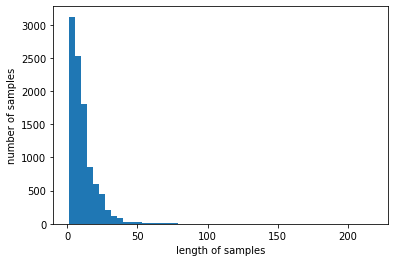

In [29]:
import matplotlib.pyplot as plt

print('시퀀스 최대 길이 :',max(len(l) for l in toknized_df['encoding']))
print('시퀀스 평균 길이 :',sum(map(len, toknized_df['encoding']))/len(toknized_df['encoding']))
plt.hist([len(s) for s in toknized_df['encoding']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

최적의 시퀀스 길이(대부분의 텍스트가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값)는?

In [30]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [31]:
max_len = 40
below_threshold_len(max_len, toknized_df['encoding'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 98.39034205231388


전체 데이터 중 약 98.7%의 샘플이 40 이하의 길이를 가짐. 모든 시퀀스 길이를 40으로 맞추기로 결정.

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoded_text = pad_sequences(toknized_df['encoding'], maxlen = max_len)

In [33]:
encoded_df = pd.DataFrame(data=encoded_text)

In [34]:
from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid = train_test_split(encoded_df, toknized_df['label'], random_state=42)

In [35]:
X_train = encoded_df
y_train = toknized_df['label']

### **Deep learning**

3. BiLSTM

In [36]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Concatenate, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(vocab_size, 100))
bilstm_model.add(Bidirectional(LSTM(100)))
bilstm_model.add(Dense(1, activation='sigmoid'))

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_bilstm = ModelCheckpoint('bilstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [39]:
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
lstm_history = bilstm_model.fit(X_train, y_train, epochs=15, callbacks=[es, mc_bilstm], batch_size=60, validation_split=0.2)

Epoch 1/15
133/133 [==============================] - 36s 119ms/step - loss: 0.5536 - acc: 0.7005 - val_loss: 0.4087 - val_acc: 0.8063

Epoch 00001: val_acc improved from -inf to 0.80634, saving model to bilstm_model.h5
Epoch 2/15
133/133 [==============================] - 12s 91ms/step - loss: 0.2788 - acc: 0.8868 - val_loss: 0.3853 - val_acc: 0.8244

Epoch 00002: val_acc improved from 0.80634 to 0.82445, saving model to bilstm_model.h5
Epoch 3/15
133/133 [==============================] - 12s 94ms/step - loss: 0.1680 - acc: 0.9341 - val_loss: 0.4781 - val_acc: 0.8129

Epoch 00003: val_acc did not improve from 0.82445
Epoch 4/15
133/133 [==============================] - 12s 89ms/step - loss: 0.1121 - acc: 0.9560 - val_loss: 0.5376 - val_acc: 0.8169

Epoch 00004: val_acc did not improve from 0.82445
Epoch 5/15
133/133 [==============================] - 12s 88ms/step - loss: 0.0759 - acc: 0.9723 - val_loss: 0.6983 - val_acc: 0.8124

Epoch 00005: val_acc did not improve from 0.82445
Epo

In [40]:
bilstm_loaded_model = load_model('bilstm_model.h5')
# print("\n 테스트 정확도: %.4f" % (bilstm_loaded_model.evaluate(X_valid, y_valid)[1]))

In [41]:
# model_json = bilstm_loaded_model.to_json()
# with open("../AIB_filter_posting/filter_app/dl_model/model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("../AIB_filter_posting/filter_app/dl_model/model.h5")

In [42]:
def preprocess_text(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    return pad_new

In [43]:
def bilstm_predict(new_sentence):
  processed_text = preprocess_text(new_sentence)
  score = float(bilstm_loaded_model.predict(processed_text)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 악의적인 글입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 악의적인 글이 아닙니다.\n".format((1 - score) * 100))

In [44]:
bilstm_predict("멍청아ㅋㅋㅋㅋㅋ")

68.20% 확률로 악의적인 글입니다.



In [45]:
bilstm_predict("이런 글이 많았으면 좋겠습니다. 늘 필요하다고 생각했습니다.")

86.09% 확률로 악의적인 글이 아닙니다.



In [46]:
bilstm_predict('에휴 ㅉㅉ 쓰레ㄱㅣ들아')

76.63% 확률로 악의적인 글입니다.



In [47]:
bilstm_predict('정말 감사합니다')

84.60% 확률로 악의적인 글이 아닙니다.



In [48]:
bilstm_predict('아 진짜 너무 귀엽다 ㅠㅠㅠ')

84.60% 확률로 악의적인 글이 아닙니다.



In [50]:
bilstm_predict('씨발')

92.48% 확률로 악의적인 글입니다.



In [51]:
bilstm_predict('ㅆㅣ발')

67.88% 확률로 악의적인 글입니다.



In [49]:
bilstm_predict('존나 멋있어')

95.13% 확률로 악의적인 글입니다.



In [52]:
bilstm_predict('진짜 못생겼다')

76.08% 확률로 악의적인 글이 아닙니다.

